<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#SDE:-Variance-Exploding" data-toc-modified-id="SDE:-Variance-Exploding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SDE: Variance Exploding</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loss</a></span></li><li><span><a href="#Custom-noising-transform" data-toc-modified-id="Custom-noising-transform-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Custom noising transform</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Denoise" data-toc-modified-id="Denoise-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Denoise</a></span><ul class="toc-item"><li><span><a href="#Forward-on-noisy-input" data-toc-modified-id="Forward-on-noisy-input-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Forward on noisy input</a></span><ul class="toc-item"><li><span><a href="#Sanity-check-visualization" data-toc-modified-id="Sanity-check-visualization-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Sanity check visualization</a></span></li></ul></li><li><span><a href="#Create-noisy-images" data-toc-modified-id="Create-noisy-images-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create noisy images</a></span></li><li><span><a href="#Denoising" data-toc-modified-id="Denoising-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Denoising</a></span><ul class="toc-item"><li><span><a href="#Lambda-scheduler" data-toc-modified-id="Lambda-scheduler-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Lambda scheduler</a></span></li><li><span><a href="#Define-denoisers" data-toc-modified-id="Define-denoisers-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Define denoisers</a></span></li><li><span><a href="#Predictor-Corrector" data-toc-modified-id="Predictor-Corrector-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Predictor Corrector</a></span></li><li><span><a href="#Euler-Maruyama" data-toc-modified-id="Euler-Maruyama-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Euler-Maruyama</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import functools
import torch
import tqdm
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch.utils.data import DataLoader

In [2]:
# if run remotely: import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    if os.path.isdir('./diffusion-for-photoacoustic/') == False:
        ! git clone https://github.com/snigdhasaha7/diffusion-for-photoacoustic.git
    sys.path.append('./diffusion-for-photoacoustic/')
# if run locally: add parent path
else:
    parent_dir = os.path.dirname(os.getcwd())
    sys.path.append(parent_dir)

In [3]:
from models import ScoreNet
from sdes import VarianceExploding

## Setup

### SDE: Variance Exploding

Variance Preserving diffusion SDE:

\begin{align*}
\text{d} \mathbf{x}
&= \sigma(t) \sqrt{2(\log(\sigma_{max}) - \log(\sigma_{min}))}  \text{d} \mathbf{w} 
\quad \quad \text{with} \ \sigma(t) = \sigma_{min} (\frac{\sigma_{max}}{\sigma_{min}})^t
\end{align*}

This SDE is associated to the following conditional Gaussian distribution:
\begin{align*}
  p(x_0|x_t) = \mathcal{N}(x_t; x_0, \sigma(t) I)
\end{align*}

In [15]:
SDE = VarianceExploding()
sde_type = 've'

In [16]:
sigma_min = .01
sigma_max = 5
marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)

### Loss

In [17]:
device = 'cuda'

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(t=random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

### Custom noising transform

In [18]:
import torch
class AddGaussianNoise():
    ''' Adds some Gaussian Noise ~ N(0, std^2 I) to an image
    '''
    # structure for custom transform follows pytorch source code
    # https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html
    def __init__(self, std=1.):
        self.std = std

    def __call__(self, image):
        ''' Add noise, returns noisy image'''
        noise = self.std * torch.randn_like(image)
        return image + noise
    def __repr__(self):
        return f"{self.__class__.__name__}()"


## Training

In [ ]:
# setup
n_epochs = 50
batch_size = 32
lr = 1e-4
noise_std = 1.

# dataset
train_transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNIST('.', train=True, transform=train_transforms, download=True);
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4);

# model + optimizer
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

# training
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in train_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0] 
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt_fashionmnist_{}epochs_{}_{}_{}.pth'.format(n_epochs, sde_type, sigma_min, sigma_max))

## Denoise

### Forward on noisy input

Noise $\sim \mathcal{N}(0, \sigma^2 \text{I}) \quad \text{with} \ \sigma=0.1$

In [20]:
noise_std = .1
test_transforms = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(noise_std)])
test_dataset = FashionMNIST('.', train=False, transform=test_transforms, download=True);
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4);

In [21]:
def get_y_t(images, t):
    # vector of t
    ts = t * torch.ones(images.shape[0], device=images.device)
    ts = ts[:, None, None, None]
    
    # sample some noise
    z = torch.randn_like(images)

    # perturb at level t
    std = marginal_prob_std_fn(t=ts)
    perturbed_images = images + z * std

    return perturbed_images

#### Sanity check visualization

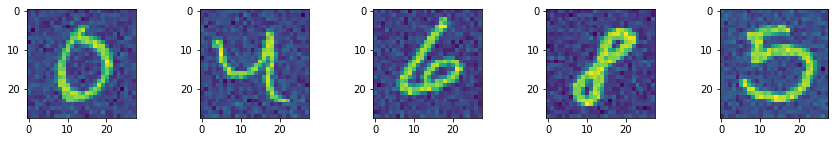

In [ ]:
num_images = 5

data, _ = next(iter(test_loader))
images = data[:num_images]

fig, axs = plt.subplots(1,num_images, figsize=(15, 2))
for i, image in enumerate(images):
    axs[i].imshow(image.permute(1, 2, 0).squeeze()
                  #, vmin=0., vmax=1.
                 ) 
plt.show()

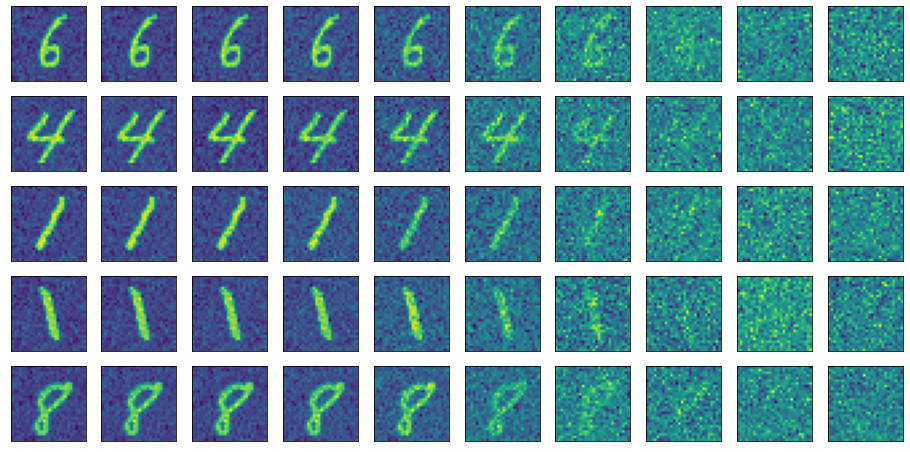

In [ ]:
num_images = 5
num_steps = 10
eps = 1e-3  # t_0 ~= 0

data, _ = next(iter(test_loader))
images = data[:num_images].to(device)
time_steps = torch.linspace(eps, 1., num_steps, device=device)

images.shape

fig, axs = plt.subplots(num_images, num_steps, figsize=(16, 8))

for j, t in enumerate(time_steps):
# for each t
    perturbed_images = get_y_t(images, t)

    # plot
    for i, image in enumerate(perturbed_images):
        axs[i][j].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
    
plt.show()

### Create noisy images

In [22]:
num_images = 5
data, _ = next(iter(test_loader))
noisy_images = data[:num_images].to(device)

### Denoising

#### Lambda scheduler

Shedulers:


\begin{align*}&\text{Constant :}\\\quad &\lambda(t) = \lambda\end{align*} \\

\begin{align*}&\text{Linear :}\\\quad &\lambda(t) = \lambda t\end{align*} \\

\begin{align*}&\text{Exponential :}\\\quad &\lambda(t) = \lambda \frac{\exp(\alpha t - 1)}{\exp(\alpha - 1)}\end{align*}




In [23]:
def lbda_scheduler(t, lbda, schedule="constant", param=1):
    if schedule == "constant":
        lbda = lbda
    elif schedule == "linear":
        param = torch.tensor(param)
        f_t = param*t
        lbda = lbda * f_t
    elif schedule == "exponential":
        param = torch.tensor(param)
        f_t = (torch.exp(param*t) - 1) / (torch.exp(param) - 1)
        lbda = lbda * f_t

    return lbda

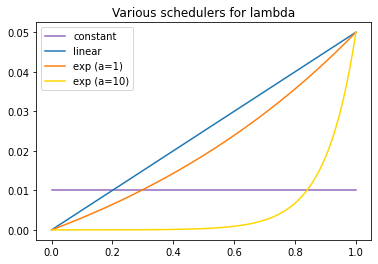

In [ ]:
ts = np.linspace(0,1,500,endpoint=True)
lbda=0.01 # constant
plt.plot(ts, 0.01*np.ones_like(ts), label="constant", color="tab:purple")

lbda = 0.05 # linear
plt.plot(ts, 0.05*ts, label="linear", color="tab:blue")

lbda = 0.05 # exponential
alpha = 1.
plt.plot(ts, 0.05*(np.exp(alpha*ts) - 1) / (np.exp(alpha) - 1), label="exp (a={})".format(int(alpha)), color="tab:orange")
alpha = 10.
plt.plot(ts, 0.05*(np.exp(alpha*ts) - 1) / (np.exp(alpha) - 1), label="exp (a={})".format(int(alpha)), color="gold")
plt.legend()
plt.title("Various schedulers for lambda")
plt.savefig('Schedulers.pdf') 
plt.show()

#### Define denoisers

In [24]:
def condition_on_y(raw_images, x_t, t, lbda=.5):
    y_t = get_y_t(raw_images, t)
    lbda = lbda_scheduler(t, lbda, schedule="constant", param=10)
    x_t_prime = lbda * y_t + (1 - lbda) * x_t
    return x_t_prime

In [25]:
def pc_denoiser(raw_images,
               score_model,
               lbda, 
               marginal_prob_std,
               diffusion_coeff,
               drift_coeff=None,
               batch_size=64, 
               num_steps=500, 
               snr=0.16,                
               device='cuda',
               eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            if drift_coeff == None:
                x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            else:
                f = drift_coeff(x, batch_time_step)
                x_mean = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size

            # Condition on y_t
            x_mean = condition_on_y(raw_images, x_mean, time_step, lbda)

            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [ ]:
def Euler_Maruyama_denoiser(raw_images,
                           score_model,
                           lbda, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           drift_coeff=None,
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if drift_coeff == None:
                mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            else:
                f = drift_coeff(x, batch_time_step)
                mean_x = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
            
            # Condition on y_t
            mean_x = condition_on_y(raw_images, mean_x, time_step, lbda)
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x

In [30]:
from torchvision.utils import make_grid

n_epochs=50

def denoise(raw_images, denoiser, lbda=.5):
    denoised = denoiser(raw_images,
                    score_model,
                    lbda,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    drift_coeff_fn,
                    raw_images.shape[0], 
                    device=device)
    return denoised

def plot_denoised(denoised):
    #denoised = denoised.clamp(0.0, 1.0)
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(denoised, nrow=int(np.sqrt(denoised.shape[0])))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()


# fresh model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
model_pth = 'ckpt_fashionmnist_{}epochs_{}_0.01_5.pth'.format(n_epochs, sde_type)
ckpt = torch.load(model_pth, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}

#### Predictor Corrector

In [36]:
## Denoise using Predictor-Corrector.
denoised_images = denoise(noisy_images, pc_denoiser, lbda=.01)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# lambda .05 + exp 1
fig, axs = plt.subplots(1, denoised_images.shape[0], figsize=(16, 8))
for i, image in enumerate(denoised_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
fig, axs = plt.subplots(1, noisy_images.shape[0], figsize=(16, 8))
for i, image in enumerate(noisy_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
# Compare control to best lambda
fig, axs = plt.subplots(2, noisy_images.shape[0], figsize=(8,4))
denoised_images = denoise(noisy_images, pc_denoiser, lbda=.015)
for j, (denoised, noisy) in enumerate(zip(denoised_images, noisy_images)):
    axs[0][j].imshow(noisy.cpu().permute(1, 2, 0).squeeze())
    axs[1][j].imshow(denoised.cpu().permute(1, 2, 0).squeeze())
    axs[0][j].set_xticks([])
    axs[0][j].set_yticks([])
    axs[1][j].set_xticks([])
    axs[1][j].set_yticks([])

axs[0][0].set_ylabel("control", rotation="horizontal", labelpad=35, fontsize=15)
axs[1][0].set_ylabel("PC\n$\lambda$=.015", rotation="horizontal", labelpad=35, fontsize=15)
plt.savefig('denoising_ve_pc.pdf')  
plt.show()

#### Euler-Maruyama

In [ ]:
## Denoise using Euler-Maruyama.
denoised_images = denoise(noisy_images, Euler_Maruyama_denoiser, lbda=.05)

  0%|          | 0/500 [00:00<?, ?it/s]

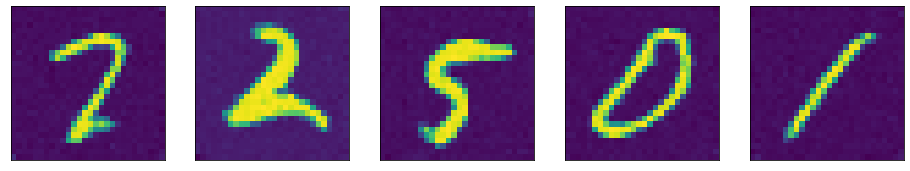

In [ ]:
fig, axs = plt.subplots(1, denoised_images.shape[0], figsize=(16, 8))
for i, image in enumerate(denoised_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

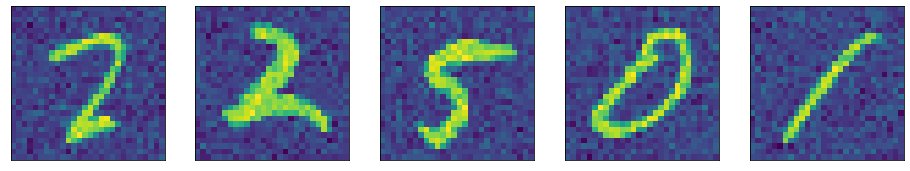

In [ ]:
fig, axs = plt.subplots(1, noisy_images.shape[0], figsize=(16, 8))
for i, image in enumerate(noisy_images):
    axs[i].imshow(image.cpu().permute(1, 2, 0).squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
# Find best lambda
lbdas = np.linspace(0.005, .015, num=10, endpoint=True)
#lbdas = np.logspace(-3, -2, num=10, endpoint=True)

fig, axs = plt.subplots(noisy_images.shape[0], len(lbdas), figsize=(16, 8))

for j, lbda in enumerate(lbdas):
    denoised_images = denoise(noisy_images, Euler_Maruyama_denoiser, lbda=lbda)
    for i, image in enumerate(denoised_images):
        axs[i][j].imshow(image.cpu().permute(1, 2, 0).squeeze())
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

for col, lbda in zip(axs[0], lbdas):
    col.set_title("$\lambda$={:.3f}".format(lbda)).set_fontsize(20)

plt.show()

In [ ]:
# Compare control to best lambda
fig, axs = plt.subplots(2, noisy_images.shape[0], figsize=(8,4))
denoised_images = denoise(noisy_images, Euler_Maruyama_denoiser, lbda=.009)
for j, (denoised, noisy) in enumerate(zip(denoised_images, noisy_images)):
    axs[0][j].imshow(noisy.cpu().permute(1, 2, 0).squeeze())
    axs[1][j].imshow(denoised.cpu().permute(1, 2, 0).squeeze())
    axs[0][j].set_xticks([])
    axs[0][j].set_yticks([])
    axs[1][j].set_xticks([])
    axs[1][j].set_yticks([])

axs[0][0].set_ylabel("control", rotation="horizontal", labelpad=35, fontsize=15)
axs[1][0].set_ylabel("$\lambda$=.009", rotation="horizontal", labelpad=35, fontsize=15)
plt.savefig('denoising_ve_em.pdf')  
plt.show()